In [1]:
# Useful starting lines
%matplotlib inline

import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from test_utils import test
import time


%load_ext autoreload
%autoreload 2

# Support Vector Machines
## Classification Using SVM
Load dataset. We will use a toy dataset from sklearn.

In [2]:
from sklearn import datasets

# Load dataset
sklearn_dataset = datasets.load_breast_cancer()
Xx = sklearn_dataset.data
y = sklearn_dataset.target * 2 - 1  # labels must be in {-1, 1} for the hinge loss
X = np.ones((Xx.shape[0], Xx.shape[1] + 1))
X[:, :-1] = Xx
print("(N, D) =", X.shape)

(N, D) = (569, 31)


## Prepare cost and prediction functions

In [3]:
def calculate_primal_objective(y, X, w, lambda_):
    """compute the full cost (the primal objective, equation (1) in the exercise pdf),
        that is loss plus regularizer.

    Args:
        X: the full dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)

    Returns:
        scalar, non-negative

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_primal_objective(y_test, x_test, w_test, 1)
    31.0
    """
    pred = X@w
    dist = y * pred
    hinge = np.maximum(0, 1 - dist)
    square_norm = w.T @ w
    l2 = lambda_ / 2 * square_norm

    return np.mean(np.maximum(0, 1 - (y*(X@w)))) + lambda_ / 2 * w.T @ w

In [4]:
test(calculate_primal_objective)

✅ Your `calculate_primal_objective` passed 4 tests.


In [5]:
def calculate_accuracy(y, X, w):
    """compute the accuracy on the given dataset (X, y) using the model w.

    Args:
        X: the full dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)

    Returns:
        scalar, between 0 and 1

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_accuracy(y_test, x_test, w_test)
    0.5
    """
    pred = X @ w > 0.0 # {0, 1}
    pred = pred * 2 - 1 # {-1, 1}
    return np.mean(y == pred)

In [6]:
test(calculate_accuracy)

✅ Your `calculate_accuracy` passed 4 tests.


## Stochastic Gradient Descent for SVM

Compute the (stochastic) subgradient for the n-th summand of the SVM optimization objective

In [7]:
def calculate_stochastic_gradient(y, X, w, lambda_, n, num_examples):
    """compute the stochastic gradient of loss plus regularizer.

    Args:
        X: the dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)
        lambda_: positive scalar number
        n: the index of the (one) datapoint we have sampled
        num_examples: N

    Returns:
        numpy array, shape = (num_features)

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_stochastic_gradient(y_test, x_test, w_test, 1, 1, 2)
    array([ 4,  6, 11])
    """

    # Extract n-th value
    x_n, y_n = X[n], y[n]
    
    # Compute subgradient of hinge loss
    dist = y_n * (x_n @ w)
    grad_hinge = -y_n * x_n if dist <= 0 else np.zeros_like(x_n)

    # Compute gradient of L2 regulariser
    grad_l2 = lambda_ * w

    # Final gradient is sum of gradients of summands
    grad = grad_hinge + grad_l2

    return grad

In [8]:
test(calculate_stochastic_gradient)

✅ Your `calculate_stochastic_gradient` passed 4 tests.


Implement stochastic gradient descent: Pick a data point uniformly at random and update w based on the gradient for the n-th summand of the objective

Final training accuracy = 89.1 %
Training time: 8.4 seconds 


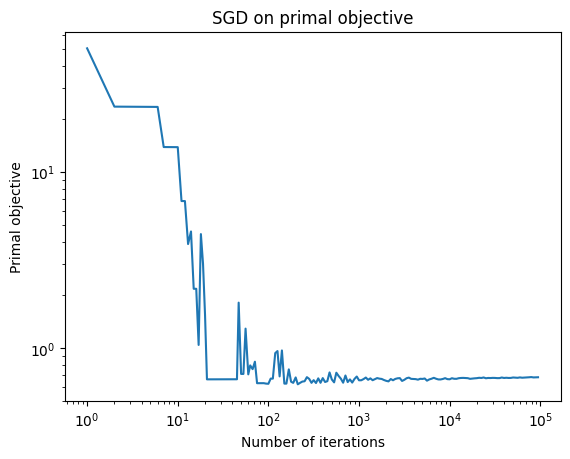

In [9]:
def sgd_for_svm_demo(y, X):
    xs = np.unique(np.round(np.logspace(0, 5, 201)))[:-1]
    max_iter = int(1e5)
    gamma = 1e-4
    lambda_ = 5e1

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    costs = []
    start = time.time()

    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0, num_examples - 1)

        grad = calculate_stochastic_gradient(y, X, w, lambda_, n, num_examples)
        w -= gamma / (it + 1) * grad

        cost = calculate_primal_objective(y, X, w, lambda_)

        if it in xs:
            costs += [cost]

    end = time.time()

    print(
        "Final training accuracy = {l} %".format(
            l=np.round(100 * calculate_accuracy(y, X, w), 2)
        )
    )
    print("Training time: " + str(np.round(end - start, 1)) + " seconds ")

    plt.figure()
    plt.title("SGD on primal objective")
    plt.loglog(xs, costs)
    plt.xlabel("Number of iterations")
    plt.ylabel("Primal objective")
    plt.show()


sgd_for_svm_demo(y, X)

## Coordinate Descent (Ascent) for SVM

Compute the closed-form update for the n-th variable alpha, in the dual optimization problem, given alpha and the current corresponding w

In [54]:
def calculate_coordinate_update(y, X, lambda_, alpha, w, n):
    """compute a coordinate update (closed form) for coordinate n.

    Args:
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        X: the dataset matrix, shape = (num_examples, num_features)
        lambda_: positive scalar number
        alpha: vector of dual coordinates, shape = (num_examples)
        w: vector of primal parameters, shape = (num_features)
        n: the coordinate to be updated

    Returns:
        w: updated vector of primal parameters, shape = (num_features)
        alpha: updated vector of dual parameters, shape = (num_examples)

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1., 2., 3.], [4., 5., 6.]])
    >>> w_test = np.array([-0.3, -0.3, -0.3])
    >>> alpha_test = np.array([.1, .1])
    >>> calculate_coordinate_update(y_test, x_test, 1, alpha_test, w_test, 0)
    (array([-0.1,  0.1,  0.3]), array([0.3, 0.1]))
    """
    # calculate the update of coordinate at index=n.
    x_n, y_n = X[n], y[n]
    old_alpha_n = np.copy(alpha[n])

    N = len(y)
    gamma_star = (lambda_ * N) * (1 - y_n * (w.T @ x_n)) / (x_n.T @ x_n)

    # Update dual parameters
    new_alpha_n = min(max(old_alpha_n + gamma_star, 0), 1)
    alpha[n] = new_alpha_n

    # Update primal parameters
    w += 1 / (lambda_ * N) * (new_alpha_n - old_alpha_n) * y_n * x_n

    return w, alpha

In [55]:
test(calculate_coordinate_update)

❌ The are some issues with your implementation of `calculate_coordinate_update`:
**********************************************************************
File "__main__", line 20, in calculate_coordinate_update
Failed example:
    calculate_coordinate_update(y_test, x_test, 1, alpha_test, w_test, 0)
Expected:
    (array([-0.1,  0.1,  0.3]), array([0.3, 0.1]))
Got:
    (array([-0.1,  0.1,  0.3]), array([0.5, 0.1]))
**********************************************************************


In [81]:
def calculate_dual_objective(y, X, w, alpha, lambda_):
    """calculate the objective for the dual problem.

    Args:
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        X: the dataset matrix, shape = (num_examples, num_features)
        w: vector of primal parameters, shape = (num_features)
        alpha: vector of dual coordinates, shape = (num_examples)
        lambda_: non negative scalar number

    Output:
        scalar

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1., 2., 3.], [4., 5., 6.]])
    >>> w_test = np.array([-0.3, -0.3, -0.3])
    >>> alpha_test = np.array([.1, .1])
    >>> calculate_dual_objective(y_test, x_test, w_test, alpha_test, 1)
    0.065
    """
    # Parameters
    N = len(y)
    Y = np.diag(y)
    Q = alpha.T @ Y.T @ X @ X.T @ Y @ alpha

    # Compute dual objective
    dual_loss = 1 / N * np.sum(alpha) - 1 / (2 * lambda_ * N**2) * Q

    return dual_loss

In [82]:
test(calculate_dual_objective)

❌ The are some issues with your implementation of `calculate_dual_objective`:
**********************************************************************
File "__main__", line 18, in calculate_dual_objective
Failed example:
    calculate_dual_objective(y_test, x_test, w_test, alpha_test, 1)
Expected:
    0.065
Got:
    0.06625
**********************************************************************


In [ ]:
# Notice that the gap is going to 0
def coordinate_descent_for_svm_demo(y, X):
    max_iter = int(1e5)
    xs = np.unique(np.round(np.logspace(0, 5, 201)))[:-1]
    lambda_ = 5e1
    p_costs, d_costs = [], []

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    start = time.time()

    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0, num_examples - 1)

        w, alpha = calculate_coordinate_update(y, X, lambda_, alpha, w, n)

        if it in xs:
            # primal objective
            primal_value = calculate_primal_objective(y, X, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, X, w, alpha, lambda_)
            # store values
            p_costs += [primal_value]
            d_costs += [dual_value]

    end = time.time()
    plt.figure()
    plt.title("Coordinate ascent on dual objective")
    plt.loglog(xs, p_costs, label="Primal cost")
    plt.loglog(xs, d_costs, label="Dual cost")
    plt.xlabel("Number of iterations")
    plt.legend()
    plt.show()

    print(
        "Final training accuracy = {l} %".format(
            l=np.round(100 * calculate_accuracy(y, X, w), 2)
        )
    )
    print("Training time: " + str(np.round(end - start, 1)) + " seconds ")


coordinate_descent_for_svm_demo(y, X)

#### The gap between the primal cost and the dual cost should go to 0 !